- Reference:[https://www.kaggle.com/yamqwe/time-series-modeling-lstm](https://www.kaggle.com/yamqwe/time-series-modeling-lstm)

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import gc
##data and date
dat = pd.read_csv('./data/train.csv')
dat = dat.set_index('timestamp')
info = pd.read_csv('./data/asset_details.csv')
assets_names = dict(zip(info.Asset_ID, info.Asset_Name))
dat['Asset_name'] = dat.Asset_ID.map(assets_names)
dat['asset_count'] = 1
#should be 14 for each timestamp when consistant
dat['asset_count'] = dat.groupby(by = dat.index)['asset_count'].sum()
dat.head()
all_same_time = dat[dat['asset_count'] == 14]
all_same_time = all_same_time.drop('asset_count',axis=1)
all_same_time.head()

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target,Asset_name
timestamp,,,,,,,,,,
1555080120,3,27.0,0.083884,0.084370,0.083580,0.083781,80185.077855,0.083865,-0.004230,Cardano
1555080120,2,111.0,282.797500,283.680000,280.470000,282.130000,705.921433,282.158407,-0.000243,Bitcoin Cash
1555080120,0,12.0,17.842500,17.850000,17.835100,17.850000,124.380000,17.844331,0.000784,Binance Coin
1555080120,1,331.0,5061.943863,5105.900000,5029.570000,5061.312857,27.275491,5062.237903,-0.000363,Bitcoin
1555080120,4,14.0,0.002777,0.002779,0.002776,0.002777,610439.000000,0.002777,0.006113,Dogecoin


## Target correlation map

0

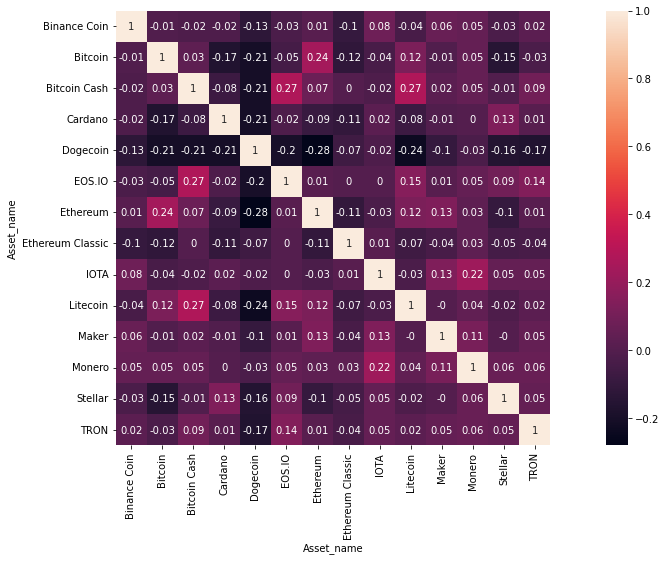

In [2]:
corr_target = all_same_time.reset_index().pivot(index = 'Asset_name', columns = 'timestamp')['Target'].transpose().corr()
fig, ax = plt.subplots(figsize = (20, 8))
sns.heatmap(np.round(corr_target, 2), annot = True, ax = ax, square = True)
del all_same_time
del dat
gc.collect()

## LSTM model

In [3]:
import os
import gc
import traceback
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import pandas as pd, numpy as np
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import RobustScaler
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

pd.set_option('display.max_columns', None)
from script.LSTM.configure import *


N_ASSETS = 14, WINDOW_SIZE =15, BATCH_SIZE = 1024,EPOCHS = 20,PCT_VALIDATION=10
connecting to TPU...
Num GPUs Available:  1


### data loading

- choose which years to load

In [4]:
from script.LSTM.dataload import load_data_for_all_assets
train = load_data_for_all_assets(load_jay = False, includeextra=False).sort_values('timestamp').set_index("timestamp")
if DEBUG: train = train[10000000:]
test = pd.read_csv('./data/' + 'example_test.csv')
sample_prediction_df = pd.read_csv('./data/' + 'example_sample_submission.csv')

assets = pd.read_csv('./data/asset_details.csv')
assets_order = pd.read_csv('./data/supplemental_train.csv').Asset_ID[:N_ASSETS]
assets_order = dict((t,i) for i,t in enumerate(assets_order))
print("Loaded all data!")

select years INCCOMP
loading preparing


## feature encoding

In [7]:
from script.LSTM.encodefeature import get_features

train['Target'] = train['Target'].fillna(0)
VWAP_max = np.max(train[np.isfinite(train.VWAP)].VWAP)
VWAP_min = np.min(train[np.isfinite(train.VWAP)].VWAP)
train['VWAP'] = np.nan_to_num(train.VWAP, posinf=VWAP_max, neginf=VWAP_min)

df = train[['Asset_ID', 'Target']].copy()
times = dict((t,i) for i,t in enumerate(df.index.unique()))
df['id'] = df.index.map(times)
df['id'] = df['id'].astype(str) + '_' + df['Asset_ID'].astype(str)
ids = df.id.copy()
del df

train = get_features(train)
train_features = [i for i in train.columns if i not in ['Target', 'date', 'timestamp', 'Asset_ID', 'groups']]

### missing data

In [8]:
##filling missing data
train = train.sort_index()
ind = train.index.unique()
def reindex(df):
    df = df.reindex(range(ind[0],ind[-1]+60,60),method='nearest')
    df = df.fillna(method="ffill").fillna(method="bfill")
    return df
train = train.groupby('Asset_ID').apply(reindex).reset_index(0, drop=True).sort_index()
gc.collect()

(14978530, 15)

In [9]:
# Matching records and marking generated rows as 'non-real'
train['group_num'] = train.index.map(times)
train = train.dropna(subset=['group_num'])
train['group_num'] = train['group_num'].astype('int')
train['id'] = train['group_num'].astype(str) + '_' + train['Asset_ID'].astype(str)
train['is_real'] = train.id.isin(ids) * 1
train = train.drop('id', axis=1)

# Features values for 'non-real' rows are set to zeros
features = train.columns.drop(['Asset_ID','group_num','is_real'])
train.loc[train.is_real == 0, features] = 0.

In [10]:
## sort the data by time and asset_id_order
from script.LSTM.dataload import reduce_mem_usage
train['asset_order'] = train.Asset_ID.map(assets_order)
train = train.sort_values(by=['group_num', 'asset_order'])
train = reduce_mem_usage(train)
gc.collect()

Memory usage of dataframe is 1428.25 MB
Memory usage after optimization is: 828.39 MB
Decreased by 42.0%


0

In [11]:
#make 3D-numpy arrays for train and targets
targets = train['Target'].to_numpy().reshape(-1, N_ASSETS)
features = train.columns.drop(['Asset_ID', 'Target', 'group_num', 'is_real', 'date'])

train = train[features]
train = train.values
train = train.reshape(-1, N_ASSETS, train.shape[-1])

X_train, X_test = train[:-len(train)//PCT_VALIDATION], train[-len(train)//PCT_VALIDATION:]
y_train, y_test = targets[:-len(train)//PCT_VALIDATION], targets[-len(train)//PCT_VALIDATION:]

### dataset windowing

Samples with a duration of `WINDOW_SIZE` records (minutes) will be formed from the train array. Each sample has a target vector corresponding to the final index if `WINDOW_SIZE` record.

In [12]:
from script.LSTM.datasetwindow import sample_generator

In [13]:
train_generator = sample_generator(X_train, y_train, length = WINDOW_SIZE, batch_size = BATCH_SIZE)
val_generator = sample_generator(X_test, y_test, length = WINDOW_SIZE, batch_size = BATCH_SIZE)
print(f'Sample shape: {train_generator[0][0].shape}')#batch_0, window, n_assets, features
print(f'Target shape: {train_generator[0][1].shape}')#batch_0, N_ASSETS

Sample shape: (1024, 15, 14, 13)
Target shape: (1024, 14)


## Compiling model

Our model will be trained for the number of `FOLDS` and `EPOCHS` you chose in the configuration above. Each fold the model with lowest validation loss will be saved and used to predict `OOF`(Out of fold) and test. Adjust the variable `VERBOSE`. The variable `VERBOSE=1 or 2` will display the training and validation loss for each epoch as text.

In [14]:
from script.LSTM.trainmodel import get_model

model = get_model(n_assets=14,
                trainshape=(train_generator[0][0].shape[1], 14, train_generator[0][0].shape[-1]))
model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2021-11-24 16:30:57.376304: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2021-11-24 16:30:57.377125: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 14, 13)] 0                                            
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 15, 13)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 15, 13)       0           input_1[0][0]                    
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 15, 13)       0           input_1[0][0]                    
______________________________________________________________________________________________

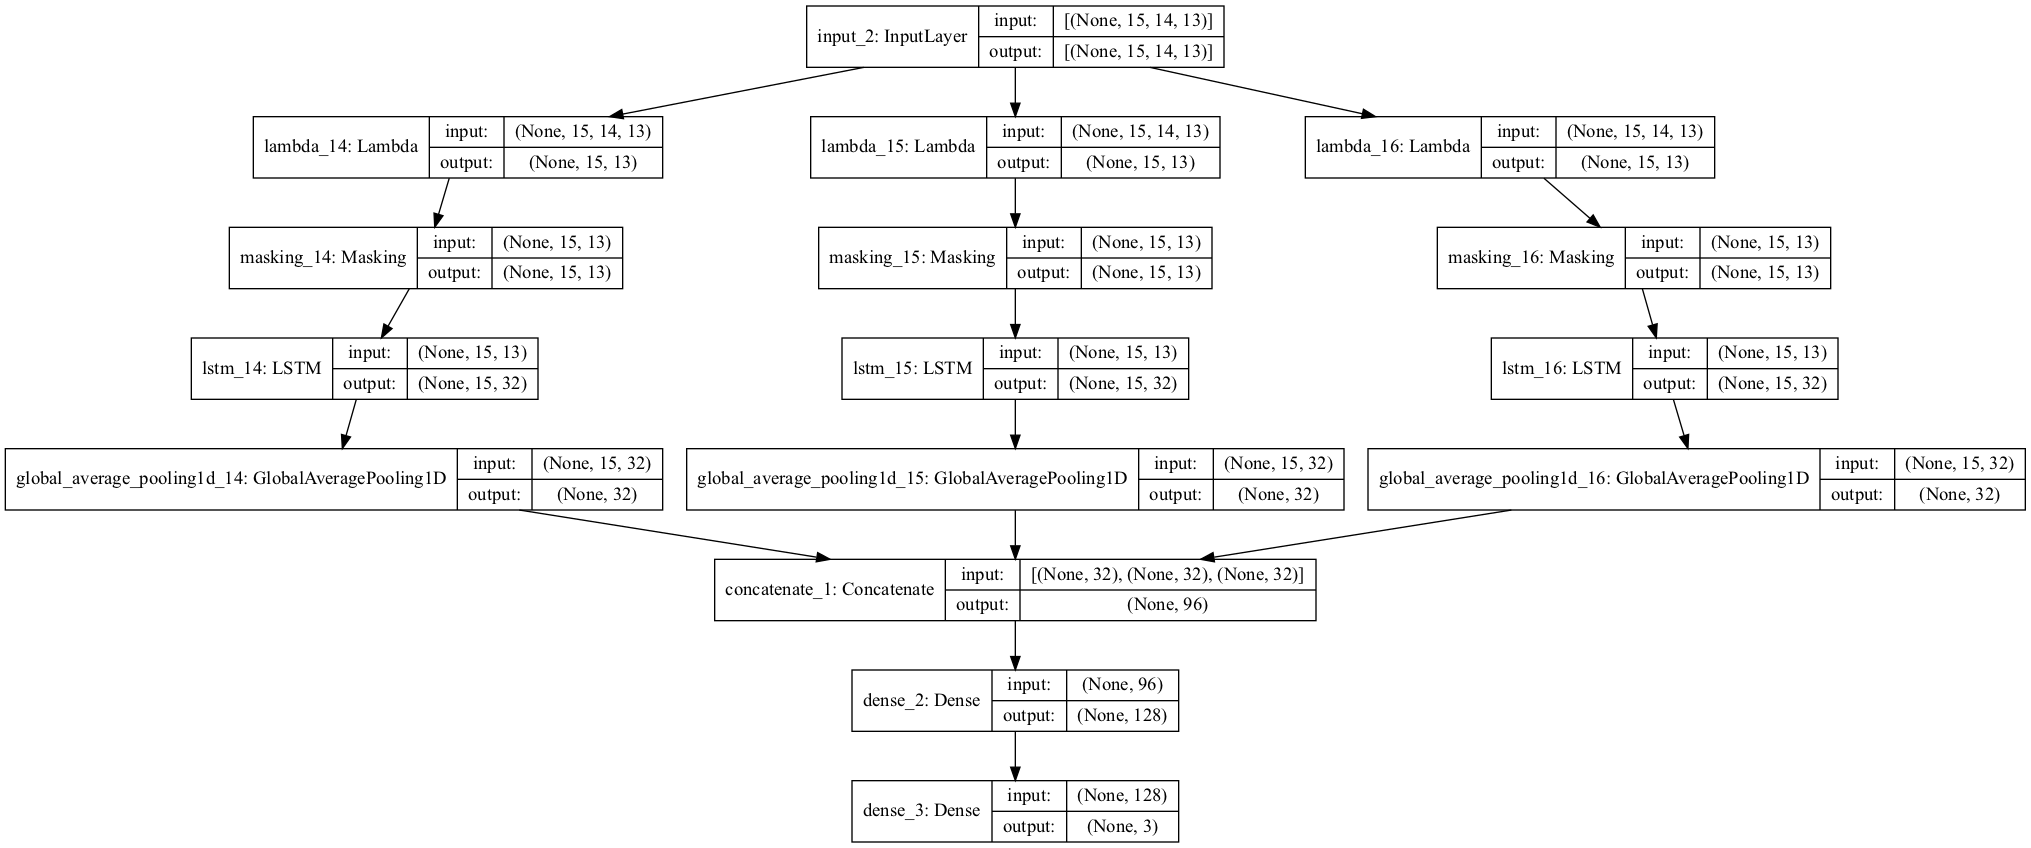

In [15]:
tf.keras.utils.plot_model(get_model(n_assets=3), show_shapes=True,to_file='./pic/lstm-kaggle.png')

## Fitting model

In [16]:
print(features)

tf.random.set_seed(0)
estop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 7, verbose = 0, mode = 'min',restore_best_weights = True)
scheduler = keras.optimizers.schedules.ExponentialDecay(1e-3, (0.5 * len(X_train) / BATCH_SIZE), 1e-3)
lr = keras.callbacks.LearningRateScheduler(scheduler, verbose = 1)

history = model.fit(train_generator, validation_data = (val_generator), 
                    epochs = EPOCHS, callbacks = [lr, estop])
model.save("kaggleLSTM")

Index(['Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP',
       'Upper_Shadow', 'Lower_Shadow', 'spread', 'mean_trade',
       'log_price_change', 'asset_order'],
      dtype='object')
Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to tf.Tensor(0.001, shape=(), dtype=float32).


2021-11-24 16:31:01.395201: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2021-11-24 16:31:01.396282: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2021-11-24 16:31:10.353793: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 16:31:11.874685: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 16:31:11.968879: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 16:31:12.065352: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 16:31:12.171129: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:11

941/941 [==============================] - ETA: 0s - loss: -0.0031 - Correlation: 0.0227

2021-11-24 16:35:05.254650: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 16:35:05.970547: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 16:35:06.013228: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 16:35:06.057269: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 16:35:06.132613: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 16:35:06.189565: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 16:35:06.252409: I tensorflow/core/grappler/optimizers/cust

941/941 [==============================] - 253s 254ms/step - loss: -0.0031 - Correlation: 0.0227 - val_loss: -0.0041 - val_Correlation: 0.0211
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to tf.Tensor(0.0009854132, shape=(), dtype=float32).
941/941 [==============================] - 230s 245ms/step - loss: -0.0062 - Correlation: 0.0233 - val_loss: -0.0041 - val_Correlation: 0.0219
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to tf.Tensor(0.0009710392, shape=(), dtype=float32).
941/941 [==============================] - 233s 247ms/step - loss: -0.0069 - Correlation: 0.0239 - val_loss: -0.0030 - val_Correlation: 0.0177
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to tf.Tensor(0.00095687475, shape=(), dtype=float32).
941/941 [==============================] - 233s 248ms/step - loss: -0.0079 - Correlation: 0.0237 - val_loss: -0.0049 - val_Correlation: 0.0228
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learni

2021-11-24 17:18:52.002194: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: kaggleLSTM/assets


INFO:tensorflow:Assets written to: kaggleLSTM/assets


In [17]:
'''from script.LSTM.trainmodel import *
model = keras.models.load_model("kaggleLSTM",custom_objects={"masked_cosine": masked_cosine, 
                                                    'Correlation':Correlation})'''

'from script.LSTM.trainmodel import *\nmodel = keras.models.load_model("kaggleLSTM",custom_objects={"masked_cosine": masked_cosine, \n                                                    \'Correlation\':Correlation})'

[https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object](https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object)

External losses & metrics added via `model.add_loss()` & `model.add_metric()` are not saved (unlike `SavedModel`)

from script.LSTM.trainmodel import *
save_path = "./trainedNN"
model= tf.keras.models.load_model(os.path.join(save_path,"lstm-updates.h5"),
                                    custom_objects={"masked_cosine": masked_cosine, 
                                                    'Correlation':Correlation},
                                    compile = False
                                    )

custom_objects={"masked_cosine": masked_cosine,'Correlation':Correlation}
with keras.utils.custom_object_scope(custom_objects):
    model= tf.keras.models.load_model(os.path.join(save_path,"lstm-updates.h5"))


/var/folders/_0/sgv1wmb92l11hndgfl0tyvjr0000gn/T/ipykernel_50143/3716941494.py:18: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


1627677

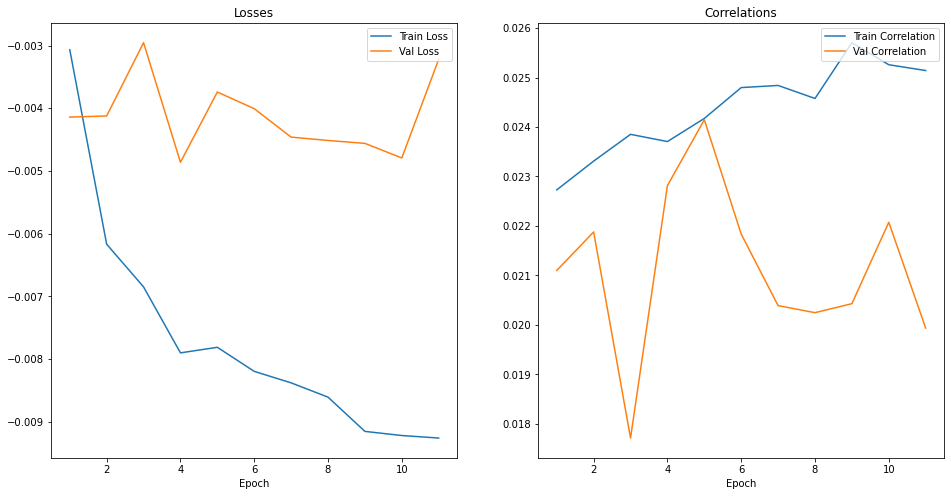

In [18]:

fig, ax = plt.subplots(1, 2, figsize=(16, 8))
histories = pd.DataFrame(history.history)
epochs = list(range(1,len(histories)+1))
loss = histories['loss']
val_loss = histories['val_loss']
Correlation = histories['Correlation']
val_Correlation = histories['val_Correlation']
ax[0].plot(epochs, loss, label = 'Train Loss')
ax[0].plot(epochs, val_loss, label = 'Val Loss')
ax[0].set_title('Losses')
ax[0].set_xlabel('Epoch')
ax[0].legend(loc='upper right')
ax[1].plot(epochs, Correlation, label = 'Train Correlation')
ax[1].plot(epochs, val_Correlation, label = 'Val Correlation')
ax[1].set_title('Correlations')
ax[1].set_xlabel('Epoch')
ax[1].legend(loc='upper right')
fig.show()
gc.collect()



In [19]:
# The correlation coefficients by asset for the validation data
predictions = model.predict(val_generator)

print('Asset:    Corr. coef.')
print('---------------------')
for i in range(N_ASSETS):
    # drop first 14 values in the y_test, since they are absent in val_generator labels
    y_true = np.squeeze(y_test[WINDOW_SIZE - 1:, i])
    y_pred = np.squeeze(predictions[:, i])
    real_target_ind = np.argwhere(y_true!=0)
    asset_id = list(assets_order.keys())[i]
    asset_name = assets[assets.Asset_ID == asset_id]['Asset_Name'].item()
    print(f"{asset_name}: {np.corrcoef(y_pred[real_target_ind].flatten(), y_true[real_target_ind].flatten())[0,1]:.4f}")

2021-11-24 17:19:13.708095: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 17:19:14.489969: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 17:19:14.560264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 17:19:14.618536: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 17:19:14.701197: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 17:19:14.795479: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.
2021-11-24 17:19:14.851132: I tensorflow/core/grappler/optimizers/cust

Asset:    Corr. coef.
---------------------
Cardano: 0.0151
Bitcoin Cash: -0.0152
Binance Coin: 0.0052
Bitcoin: 0.0218
Dogecoin: 0.0020
EOS.IO: 0.0004
Ethereum Classic: -0.0166
Ethereum: -0.0012
IOTA: 0.0113
Litecoin: 0.0095
Maker: -0.0039
TRON: -0.0208
Stellar: 0.0036
Monero: 0.0265


# Submission